In [1]:
import tensorflow as tf 
import numpy as np 
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.mnist.load_data()

In [3]:
def plot_fig(X, y):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('Training: %i\n' % int(label), fontsize = 20)

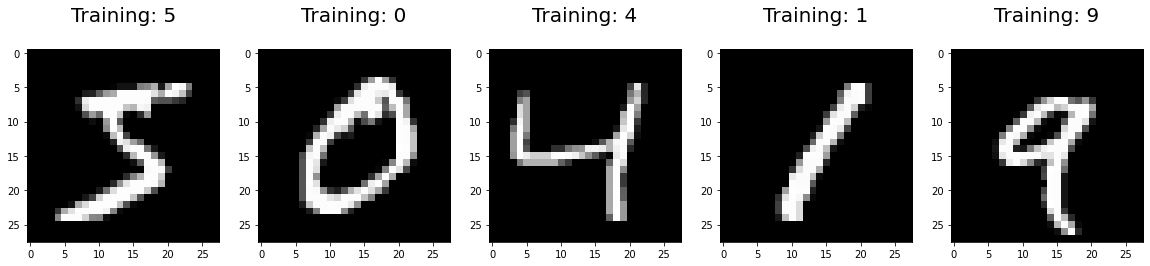

In [4]:
plot_fig(X_train, Y_train)

In [5]:
def unbalanced_dataset(X_train, Y_train):
    x_train = []
    y_train = []
    
    x_val = []
    y_val = []
    
    for i in range(0, len(X_train)):
        rdm1 = random.uniform(0, 1)
        rdm2 = random.uniform(0, 1)
        if (Y_train[i]%2 ==0):
            if rdm1>0.4:
                x_train.append(X_train[i])
                y_train.append(Y_train[i])
        else:
            if rdm2>0.1:
                x_train.append(X_train[i])
                y_train.append(Y_train[i])
                
                
    for i in range(0, len(X_val)):
        rdm1 = random.uniform(0, 1)
        rdm2 = random.uniform(0, 1)
        if (Y_val[i]%2 ==0):
            if rdm1>0.4:
                x_val.append(X_val[i])
                y_val.append(Y_val[i])
        else:
            if rdm2>0.1:
                x_val.append(X_val[i])
                y_val.append(Y_val[i])
                
                
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val)


In [6]:
x_train_ub, y_train_ub, x_val_ub, y_val_ub = unbalanced_dataset(X_train, Y_train)

In [7]:
def check_class_distribution(y_train):
    class_frq = {}
    for val in y_train:
        if class_frq.get(val) is not None:
            class_frq[val] = class_frq.get(val) +1
        else:
            class_frq[val] = 1
    class_frq
    
    return class_frq

In [8]:
print("Class Distribution: ", check_class_distribution(y_train_ub))

Class Distribution:  {5: 4897, 0: 3613, 4: 3533, 9: 5322, 2: 3527, 1: 6019, 3: 5519, 7: 5641, 6: 3472, 8: 3458}


In [9]:
def preprocess_data(x_train, y_train, x_val, y_val):
    """
    Return nomalized X and one-hot encoded Y-label 
    """
    # expand new axis, channel axis 
    x_train = np.expand_dims(x_train, axis=-1)
    # [optional]: we may need 3 channel (instead of 1)
    x_train = np.repeat(x_train, 3, axis=-1)
    # it's always better to normalize 
    x_train = x_train.astype('float32') / 255
    # resize the input shape , i.e. old shape: 28, new shape: 32
    x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
    
    x_val = np.expand_dims(x_val, axis=-1)
    x_val = np.repeat(x_val, 3, axis=-1)
    x_val = x_val.astype('float32') / 255
    x_val = tf.image.resize(x_val, [32,32]) # if we want to resize 
    
    # one hot 
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val , num_classes=10)

    return x_train, y_train, x_val, y_val

In [10]:
x_train, y_train, x_val, y_val = preprocess_data(X_train, Y_train,X_val, Y_val)

2021-11-16 22:43:31.169696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:43:31.178496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:43:31.179161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:43:31.180308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
x_train_ub, y_train_ub, x_val_ub, y_val_ub = preprocess_data(x_train_ub, y_train_ub, x_val_ub, y_val_ub)

In [12]:
class LDAMLoss():

    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list)+0.000005)
        m_list = m_list * (max_m / np.max(m_list))
        m_list = tf.convert_to_tensor(m_list, dtype=tf.float32)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight
        self.n_classes = len(cls_num_list)

    def __call__(self, target, x):
        # contrary to pytorch implemenation, our labels are already one hot encoded
        index_float = target
        #self.m_list =np.reshape(self.m_list, (10,1))
        batch_m = tf.matmul(self.m_list[None, :], tf.transpose(index_float))
        batch_m = tf.reshape(batch_m, (-1, 1))
        x_m = x - batch_m

        # if condition is true, return x_m[index], otherwise return x[index]
        index_bool = tf.cast(index_float, tf.bool)
        output = tf.where(index_bool, x_m, x)

        labels = index_float
        logits = output
        #print("labels : \n", labels, "\n logits : \n", logits)
        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits*self.s)
        return tf.reduce_mean(loss)

In [13]:
def model_with_LDAM(x_train, y_train, x_val=None, y_val=None):
    input = tf.keras.Input(shape=(32,32,3))
    efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                                 include_top = False, 
                                                 input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

    # bind all
    model = tf.keras.Model(efnet.input, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=LDAMLoss([0,1,2,3,4,5,6,7,8,9]),
              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(10),tf.keras.metrics.AUC()])

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose = 2, batch_size=64)
    

In [14]:
model_with_LDAM(x_train_ub, y_train_ub, x_val_ub, y_val_ub) # training on unbalanced data

2021-11-16 22:43:40.172868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-16 22:43:46.737541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


704/704 - 39s - loss: 0.8240 - accuracy: 0.9094 - precision: 0.9618 - recall: 0.4043 - f1_score: 0.9055 - auc: 0.9769 - val_loss: 3.4676 - val_accuracy: 0.3437 - val_precision: 1.0000 - val_recall: 0.0600 - val_f1_score: 0.2380 - val_auc: 0.8311
Epoch 2/10
704/704 - 30s - loss: 0.1840 - accuracy: 0.9710 - precision: 0.9960 - recall: 0.4290 - f1_score: 0.9701 - auc: 0.9969 - val_loss: 0.4709 - val_accuracy: 0.9301 - val_precision: 0.9902 - val_recall: 0.3723 - val_f1_score: 0.9275 - val_auc: 0.9945
Epoch 3/10
704/704 - 29s - loss: 0.4336 - accuracy: 0.9392 - precision: 0.9867 - recall: 0.2977 - f1_score: 0.9372 - auc: 0.9901 - val_loss: 0.2162 - val_accuracy: 0.9701 - val_precision: 0.9898 - val_recall: 0.5012 - val_f1_score: 0.9678 - val_auc: 0.9953
Epoch 4/10
704/704 - 29s - loss: 0.1140 - accuracy: 0.9792 - precision: 0.9979 - recall: 0.3515 - f1_score: 0.9786 - auc: 0.9984 - val_loss: 0.0754 - val_accuracy: 0.9855 - val_precision: 0.9997 - val_recall: 0.4083 - val_f1_score: 0.9850 -

In [15]:
model_with_LDAM(x_train, y_train, x_val, y_val) # training on balance dataset (default MNIST dataset)

2021-11-16 22:48:47.327956: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/10
938/938 - 46s - loss: 0.4979 - accuracy: 0.9330 - precision_1: 0.9852 - recall_1: 0.4644 - f1_score: 0.9325 - auc_1: 0.9889 - val_loss: 0.2200 - val_accuracy: 0.9584 - val_precision_1: 0.9978 - val_recall_1: 0.2226 - val_f1_score: 0.9587 - val_auc_1: 0.9956
Epoch 2/10
938/938 - 39s - loss: 0.1254 - accuracy: 0.9776 - precision_1: 0.9973 - recall_1: 0.4117 - f1_score: 0.9774 - auc_1: 0.9981 - val_loss: 0.0802 - val_accuracy: 0.9847 - val_precision_1: 0.9990 - val_recall_1: 0.5237 - val_f1_score: 0.9845 - val_auc_1: 0.9989
Epoch 3/10
938/938 - 39s - loss: 0.1226 - accuracy: 0.9793 - precision_1: 0.9970 - recall_1: 0.4319 - f1_score: 0.9792 - auc_1: 0.9982 - val_loss: 0.0707 - val_accuracy: 0.9877 - val_precision_1: 0.9996 - val_recall_1: 0.5053 - val_f1_score: 0.9877 - val_auc_1: 0.9994
Epoch 4/10
938/938 - 39s - loss: 0.0821 - accuracy: 0.9851 - precision_1: 0.9985 - recall_1: 0.5060 - f1_score: 0.9850 - auc_1: 0.9991 - val_loss: 0.0878 - val_accuracy: 0.9833 - val_precision_